### Get fetalization gene scores for disease subtypes. 

We will use the `score_genes()` function in scanpy to get the fetalization gene signature, and then pseudobulk at the donor level.

In [1]:
import numpy as np
import scanpy as sc 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
import scipy.stats as stats
import os
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
results_dir = "fetalization_results/"
os.makedirs(results_dir, exist_ok=True)

In [3]:
%%time
adata = sc.read_h5ad("../07_final_RNA_without_scvi.h5ad")

CPU times: user 11.5 s, sys: 56.7 s, total: 1min 8s
Wall time: 1min 9s


Do for all of the fetalization cell types (not Adipocytes, Endocardial, Mast)

In [4]:
cell_types =  ["Cardiomyocyte", "Endothelial", "Epicardial",
             "Fibroblast", "LEC", "Lymphoid", "Myeloid", "Neuronal", "Pericyte", "vSMC"]

#### Iterate through all cell types

Cardiomyocyte


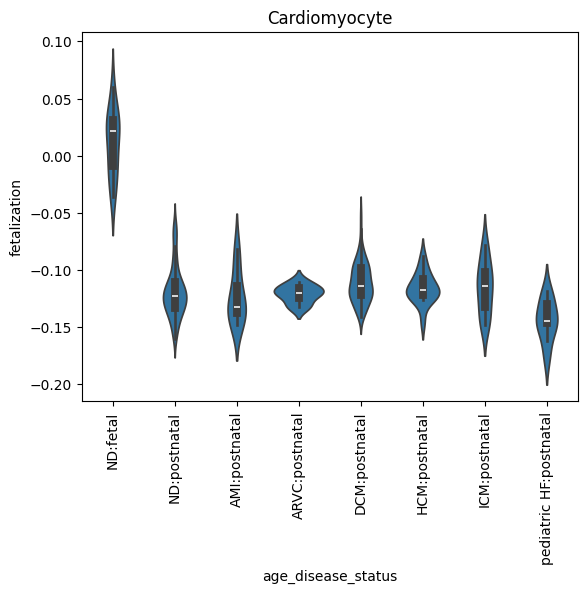

Endothelial


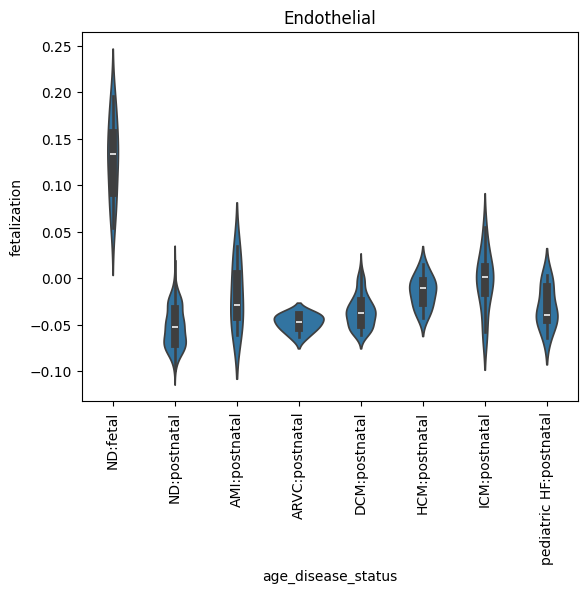

Epicardial


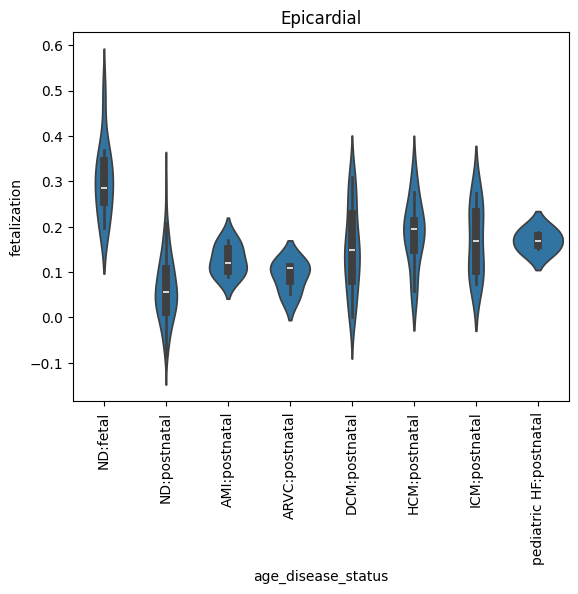

Fibroblast


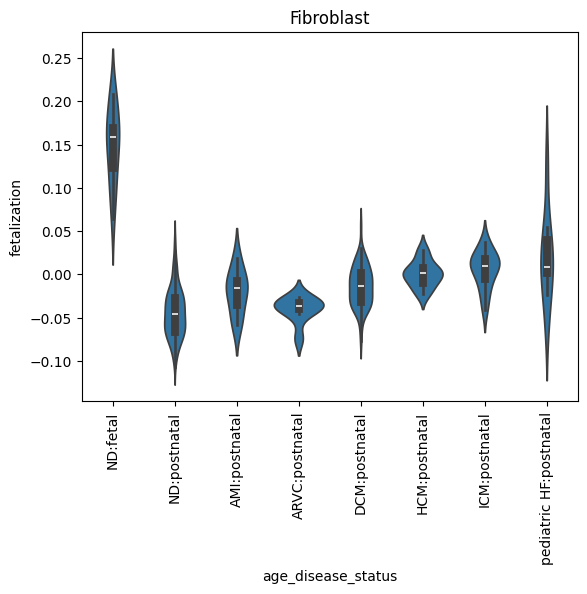

LEC


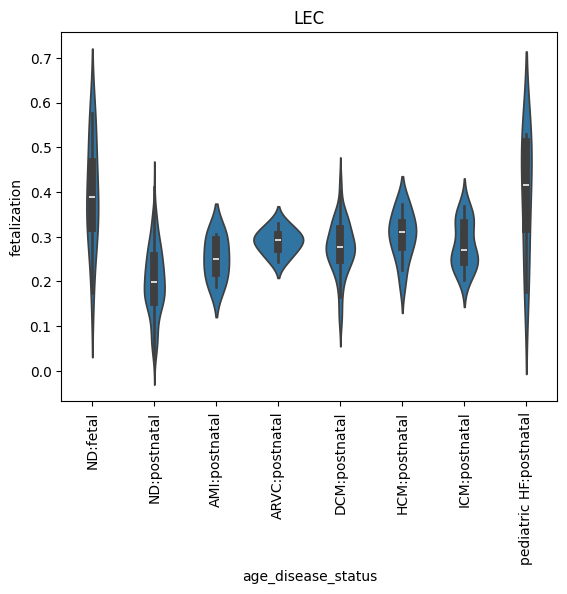

Lymphoid


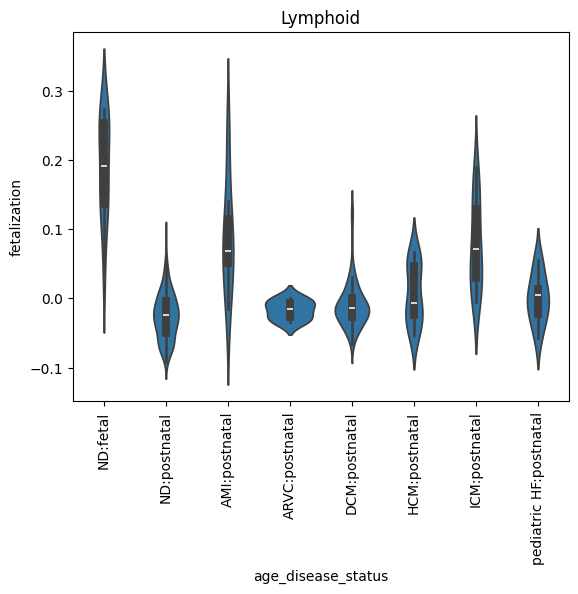

Myeloid


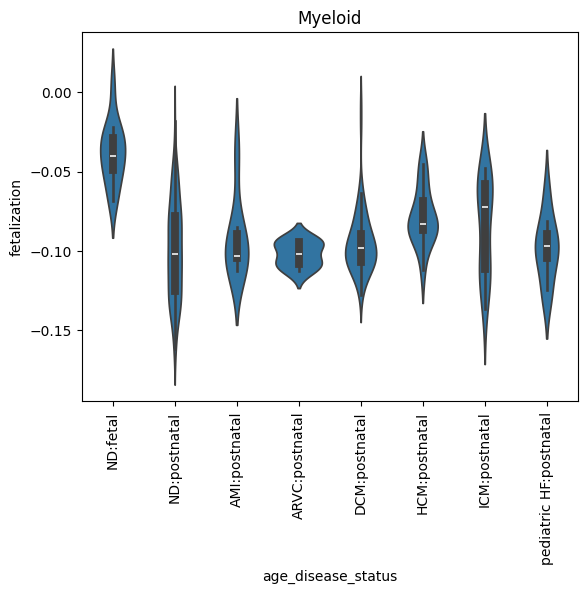

Neuronal


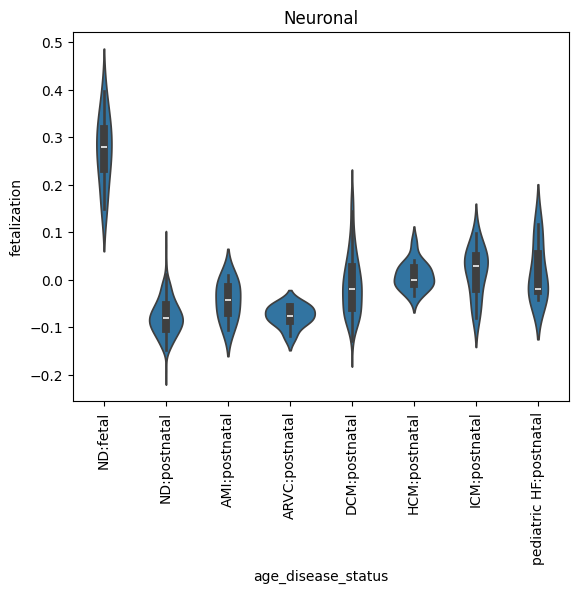

Pericyte


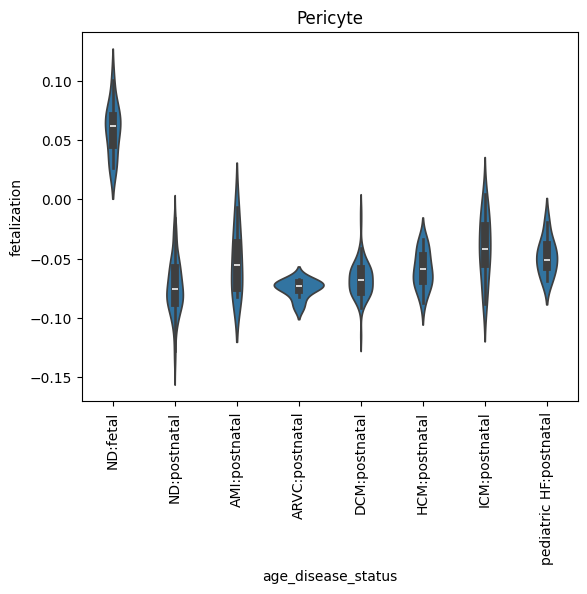

vSMC


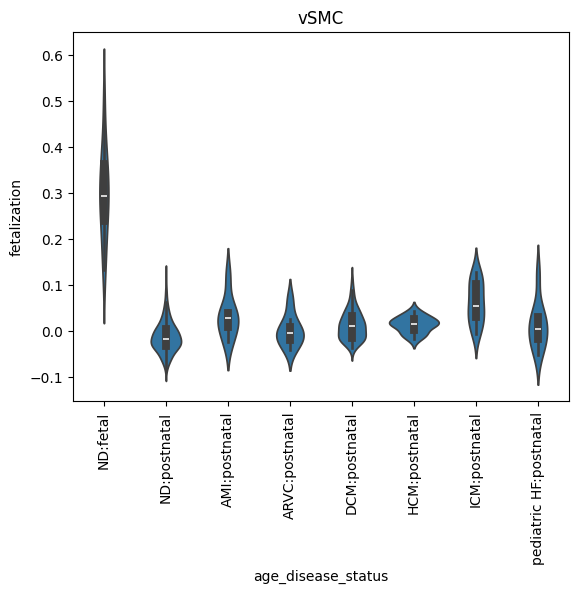

In [5]:
reference_group = "ND:postnatal" # non-diseased reference group

# order for violin plot
desired_order = ['ND:fetal', 'ND:postnatal', 'AMI:postnatal', 'ARVC:postnatal', 'DCM:postnatal', 
                 'HCM:postnatal', 'ICM:postnatal', 'pediatric HF:postnatal']

# list to store the results
results = []

for cell_type in cell_types:
    print(cell_type, flush=True)
    
    # subset the adata
    subset_adata = adata[adata.obs.final_cell_type == cell_type].copy()

    # fetch the fetalization genes
    fetalization_genes = list(pd.read_csv("../pseudobulked_analysis/pydeseq2/fetalization_genes/" + cell_type + 
                                      "_up_fetalization_genes.csv")['0'])

    # per cell, get the fetalization score
    sc.tl.score_genes(subset_adata, fetalization_genes, score_name="fetalization")

    # get the metadata
    subset_adata_metadata = subset_adata.obs

    # combine disease + age
    subset_adata_metadata['age_disease_status'] = ( subset_adata_metadata['disease'].astype(str) + ":" + 
                                                   subset_adata_metadata['age_status'].astype(str)) 

    # pseudobulk and get the mean fetalization value per donor
    mean_fetalization_scores = ( subset_adata_metadata.groupby(['donor_id',
                                                                'age_disease_status'], 
                                                               observed=True)['fetalization'].mean().reset_index() )

    # remove disease statuses with low number of donors
    filt_mean_fetalization_scores = mean_fetalization_scores[~mean_fetalization_scores['age_disease_status'].isin(['NCCM:postnatal'])]

    # save as csv 
    filt_mean_fetalization_scores.to_csv(results_dir + cell_type + "_fetalization_scores.csv")

    # produce violin plot
    sns.violinplot(data = filt_mean_fetalization_scores, x = 'age_disease_status', y = 'fetalization', order = desired_order)
    plt.xticks(rotation = 90)
    plt.title(cell_type)
    plt.savefig(results_dir + cell_type + "_snRNA_fetalization_violin_plot.pdf")
    plt.show()

    ref_group = filt_mean_fetalization_scores[filt_mean_fetalization_scores['age_disease_status'] == reference_group]['fetalization']
    
    # compare all of the unique age_disease_status against "ND:postnatal" using the Mann-Whitney U test
    for group in filt_mean_fetalization_scores['age_disease_status'].unique():
        if group != "ND:postnatal": 
            test_group = filt_mean_fetalization_scores[filt_mean_fetalization_scores['age_disease_status'] == group]['fetalization']
            stat, p_value = stats.mannwhitneyu(ref_group, test_group, alternative='two-sided')
            results.append({'age_disease_status': group, 
                            'statistic': stat, 
                            'p_value': p_value,
                            'cell_type': cell_type})

# save the results to a dataframe
results_df = pd.DataFrame(results)
results_df.to_csv(results_dir + "fetalization_p_values.csv")